In [1]:
# Copyright (c) 2015-present, Facebook, Inc.
# All rights reserved.
#
# This source code is licensed under the CC-by-NC license found in the
# LICENSE file in the root directory of this source tree.
#

'''These modules are adapted from those of timm, see
https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py
'''

import torch
import torch.nn as nn
from functools import partial
import torch.nn.functional as F
from timm.models.helpers import load_pretrained
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from timm.models.registry import register_model

import torch
import torch.nn as nn
import matplotlib.pyplot as plt


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)
        self.apply(self._init_weights)
        
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
            
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class GPSA(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.,
                 locality_strength=1., use_local_init=True):
        super().__init__()
        self.num_heads = num_heads
        self.dim = dim
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.qk = nn.Linear(dim, dim * 2, bias=qkv_bias)       
        self.v = nn.Linear(dim, dim, bias=qkv_bias)       
        
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.pos_proj = nn.Linear(3, num_heads)
        self.proj_drop = nn.Dropout(proj_drop)
        self.locality_strength = locality_strength
        self.gating_param = nn.Parameter(torch.ones(self.num_heads))
        self.apply(self._init_weights)
        if use_local_init:
            self.local_init(locality_strength=locality_strength)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        
    def forward(self, x):
        B, N, C = x.shape
        if not hasattr(self, 'rel_indices') or self.rel_indices.size(1)!=N:
            self.get_rel_indices(N)

        attn = self.get_attention(x)
        v = self.v(x).reshape(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

    def get_attention(self, x):
        B, N, C = x.shape        
        qk = self.qk(x).reshape(B, N, 2, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k = qk[0], qk[1]
        pos_score = self.rel_indices.expand(B, -1, -1,-1)
        pos_score = self.pos_proj(pos_score).permute(0,3,1,2) 
        patch_score = (q @ k.transpose(-2, -1)) * self.scale
        patch_score = patch_score.softmax(dim=-1)
        pos_score = pos_score.softmax(dim=-1)

        gating = self.gating_param.view(1,-1,1,1)
        attn = (1.-torch.sigmoid(gating)) * patch_score + torch.sigmoid(gating) * pos_score
        attn /= attn.sum(dim=-1).unsqueeze(-1)
        attn = self.attn_drop(attn)
        return attn

    def get_attention_map(self, x, return_map = False):

        attn_map = self.get_attention(x).mean(0) # average over batch
        distances = self.rel_indices.squeeze()[:,:,-1]**.5
        dist = torch.einsum('nm,hnm->h', (distances, attn_map))
        dist /= distances.size(0)
        if return_map:
            return dist, attn_map
        else:
            return dist
    
    def local_init(self, locality_strength=1.):
        
        self.v.weight.data.copy_(torch.eye(self.dim))
        locality_distance = 1 #max(1,1/locality_strength**.5)
        
        kernel_size = int(self.num_heads**.5)
        center = (kernel_size-1)/2 if kernel_size%2==0 else kernel_size//2
        for h1 in range(kernel_size):
            for h2 in range(kernel_size):
                position = h1+kernel_size*h2
                self.pos_proj.weight.data[position,2] = -1
                self.pos_proj.weight.data[position,1] = 2*(h1-center)*locality_distance
                self.pos_proj.weight.data[position,0] = 2*(h2-center)*locality_distance
        self.pos_proj.weight.data *= locality_strength

    def get_rel_indices(self, num_patches):
        #img_size = int(num_patches**.5)
        #rel_indices   = torch.zeros(1, num_patches, num_patches, 3)
        #ind = torch.arange(img_size).view(1,-1) - torch.arange(img_size).view(-1, 1)
        #indx = ind.repeat(img_size,img_size)
        #indy = ind.repeat_interleave(img_size,dim=0).repeat_interleave(img_size,dim=1)
        #indd = indx**2 + indy**2
        #rel_indices[:,:,:,2] = indd.unsqueeze(0)
        #rel_indices[:,:,:,1] = indy.unsqueeze(0)
        #rel_indices[:,:,:,0] = indx.unsqueeze(0)
        #device = self.qk.weight.device
        #self.rel_indices = rel_indices.to(device)

        img_size = (1, 300)
        patch_size = (1, 300 // num_patches)

        num_patches_x = img_size[1] // patch_size[1]
        num_patches_y = img_size[0] // patch_size[0]

        rel_indices = torch.zeros(1, num_patches_x * num_patches_y, num_patches_x * num_patches_y, 3)
        ind = torch.arange(num_patches_x).view(1,-1) - torch.arange(num_patches_x).view(-1, 1)
        indx = ind.repeat(num_patches_y, 1).repeat(1, num_patches_y)
        ind = torch.arange(num_patches_y).view(1,-1) - torch.arange(num_patches_y).view(-1, 1)
        indy = ind.repeat_interleave(num_patches_y, dim=0).repeat_interleave(num_patches_y, dim=1)
        indd = indx**2 + indy**2
        rel_indices[:,:,:,2] = indd.unsqueeze(0)
        rel_indices[:,:,:,1] = indy.unsqueeze(0)
        rel_indices[:,:,:,0] = indx.unsqueeze(0)

        device = self.qk.weight.device
        self.rel_indices = rel_indices.to(device)

 
class MHSA(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        self.apply(self._init_weights)
        
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def get_attention_map(self, x, return_map = False):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn_map = (q @ k.transpose(-2, -1)) * self.scale
        attn_map = attn_map.softmax(dim=-1).mean(0)

        img_size = int(N**.5)
        ind = torch.arange(img_size).view(1,-1) - torch.arange(img_size).view(-1, 1)
        indx = ind.repeat(img_size,img_size)
        indy = ind.repeat_interleave(img_size,dim=0).repeat_interleave(img_size,dim=1)
        indd = indx**2 + indy**2
        distances = indd**.5
        distances = distances.to('cuda')

        dist = torch.einsum('nm,hnm->h', (distances, attn_map))
        dist /= N
        
        if return_map:
            return dist, attn_map
        else:
            return dist

            
    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x
    
class Block(nn.Module):

    def __init__(self, dim, num_heads,  mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm, use_gpsa=True, **kwargs):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.use_gpsa = use_gpsa
        if self.use_gpsa:
            self.attn = GPSA(dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop, **kwargs)
        else:
            self.attn = MHSA(dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop, **kwargs)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x
    

class PatchEmbed(nn.Module):
    """ Image to Patch Embedding, from timm
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.apply(self._init_weights)
    def forward(self, x):
        B, C, H, W = x.shape
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

class HybridEmbed(nn.Module):
    """ CNN Feature Map Embedding, from timm
    """
    def __init__(self, backbone, img_size=224, feature_size=None, in_chans=3, embed_dim=768):
        super().__init__()
        assert isinstance(backbone, nn.Module)
        img_size = to_2tuple(img_size)
        self.img_size = img_size
        self.backbone = backbone
        if feature_size is None:
            with torch.no_grad():
                training = backbone.training
                if training:
                    backbone.eval()
                o = self.backbone(torch.zeros(1, in_chans, img_size[0], img_size[1]))[-1]
                feature_size = o.shape[-2:]
                feature_dim = o.shape[1]
                backbone.train(training)
        else:
            feature_size = to_2tuple(feature_size)
            feature_dim = self.backbone.feature_info.channels()[-1]
        self.num_patches = feature_size[0] * feature_size[1]
        self.proj = nn.Linear(feature_dim, embed_dim)
        self.apply(self._init_weights)

    def forward(self, x):
        x = self.backbone(x)[-1]
        x = x.flatten(2).transpose(1, 2)
        x = self.proj(x)
        return x


class VisionTransformer(nn.Module):
    """ Vision Transformer with support for patch or hybrid CNN input stage
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=1000, embed_dim=48, depth=12,
                 num_heads=12, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop_rate=0., attn_drop_rate=0.,
                 drop_path_rate=0., hybrid_backbone=None, norm_layer=nn.LayerNorm, global_pool=None,
                 local_up_to_layer=10, locality_strength=1., use_pos_embed=True, **extra):
        super().__init__()

        print("ignored params", extra)

        embed_dim *= num_heads
        self.num_classes = num_classes
        self.local_up_to_layer = local_up_to_layer
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models
        self.locality_strength = locality_strength
        self.use_pos_embed = use_pos_embed

        if hybrid_backbone is not None:
            self.patch_embed = HybridEmbed(
                hybrid_backbone, img_size=img_size, in_chans=in_chans, embed_dim=embed_dim)
        else:
            self.patch_embed = PatchEmbed(
                img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches
        self.num_patches = num_patches
        
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)

        if self.use_pos_embed:
            self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
            trunc_normal_(self.pos_embed, std=.02)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer,
                use_gpsa=True,
                locality_strength=locality_strength)
            if i<local_up_to_layer else
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer,
                use_gpsa=False)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)

        # Classifier head
        self.feature_info = [dict(num_chs=embed_dim, reduction=0, module='head')]
        self.head = nn.Linear(embed_dim, num_classes) if num_classes > 0 else nn.Identity()

        trunc_normal_(self.cls_token, std=.02)
        self.head.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed', 'cls_token'}

    def get_classifier(self):
        return self.head

    def reset_classifier(self, num_classes, global_pool=''):
        self.num_classes = num_classes
        self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()

    def forward_features(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)

        if self.use_pos_embed:
            x = x + self.pos_embed
        x = self.pos_drop(x)

        for u,blk in enumerate(self.blocks):
            if u == self.local_up_to_layer :
                x = torch.cat((cls_tokens, x), dim=1)
            x = blk(x)

        x = self.norm(x)
        return x[:, 0]

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x
    
import torch
import torch.nn as nn
from functools import partial

from timm.models.efficientnet import EfficientNet
from timm.models.vision_transformer import _cfg
from timm.models.registry import register_model

@register_model
def convit_tiny(pretrained=False, **kwargs):
    num_heads = 4
    kwargs['embed_dim'] *= num_heads
    model = VisionTransformer(
        num_heads=num_heads,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    model.default_cfg = _cfg()
    if pretrained:
        checkpoint = torch.hub.load_state_dict_from_url(
            url="https://dl.fbaipublicfiles.com/convit/convit_tiny.pth",
            map_location="cpu", check_hash=True
        )
        model.load_state_dict(checkpoint)
    return model

@register_model
def convit_small(pretrained=False, **kwargs):
    num_heads = 9
    kwargs['embed_dim'] *= num_heads
    model = VisionTransformer(
        num_heads=num_heads,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    model.default_cfg = _cfg()
    if pretrained:
        checkpoint = torch.hub.load_state_dict_from_url(
            url="https://dl.fbaipublicfiles.com/convit/convit_small.pth",
            map_location="cpu", check_hash=True
        )
        model.load_state_dict(checkpoint)
    return model

@register_model
def convit_base(pretrained=False, **kwargs):
    num_heads = 16
    kwargs['embed_dim'] *= num_heads
    model = VisionTransformer(
        num_heads=num_heads,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    model.default_cfg = _cfg()
    if pretrained:
        checkpoint = torch.hub.load_state_dict_from_url(
            url="https://dl.fbaipublicfiles.com/convit/convit_base.pth",
            map_location="cpu", check_hash=True
        )
        model.load_state_dict(checkpoint)
    return model

In [166]:
convit = VisionTransformer(img_size=(1, 300), patch_size=(1, 10), in_chans=14, num_classes=8, embed_dim=64, depth=8,
                 num_heads=2, mlp_ratio=2., qkv_bias=False, qk_scale=None, drop_rate=0., attn_drop_rate=0.,
                 drop_path_rate=0., hybrid_backbone=None, norm_layer=nn.LayerNorm, global_pool=None,
                 local_up_to_layer=10, locality_strength=1., use_pos_embed=True)

localities = [[] for i in range(len(convit.blocks))]

epochs = [20, 40, 60]
for epoch in epochs:
    convit.load_state_dict(torch.load(f'vit_9_1_epoch{epoch}.pth', map_location=torch.device('cpu')))
    convit.eval()
    for layer in range(len(convit.blocks)):
        localities[layer].append(torch.sigmoid(convit.blocks[layer].attn.gating_param).detach().numpy())

ignored params {}


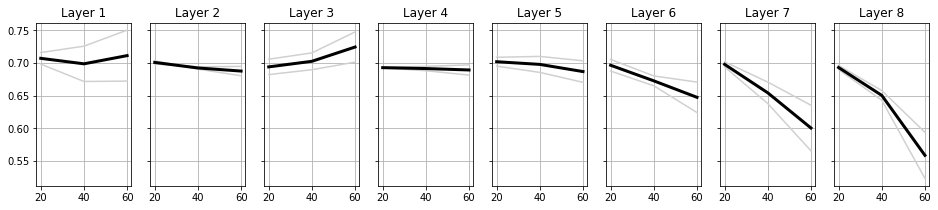

In [190]:
import numpy as np
import matplotlib.pyplot as plt

gating_epochs = np.transpose(np.array(localities), (0, 2, 1))

fig, ax = plt.subplots(figsize=(2 * gating_epochs.shape[0], 3), ncols=gating_epochs.shape[0], sharey=True)
for i in range(gating_epochs.shape[0]):
    for ii in range(gating_epochs.shape[1]):
        ax[i].plot(epochs, gating_epochs[i][ii], c='#D0D0D0')
    ax[i].plot(epochs, gating_epochs[i].mean(axis=0), c='#000000', linewidth=3.0)
    ax[i].set_title(f'Layer {i + 1}')
    ax[i].grid('on')

In [175]:
gating_epochs[i]

array([[0.689684  , 0.6428473 , 0.5232537 ],
       [0.69599307, 0.6576184 , 0.5937532 ]], dtype=float32)

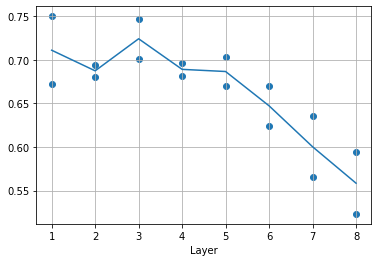

In [79]:
import matplotlib.pyplot as plt

l = [torch.sigmoid(convit.blocks[i].attn.gating_param).detach().numpy().mean() for i in range(len(convit.blocks))]
plt.plot(list(range(1, len(l) + 1)), l)
for i in range(len(convit.blocks)):
    plt.scatter([i + 1, i + 1], torch.sigmoid(convit.blocks[i].attn.gating_param).detach().numpy(), color='C0')
plt.xlabel('Layer')
plt.grid('on')
#plt.ylim([0, 1])